## 1. Human Feature Analysis

In [ ]:
#Setup
import cv2
import numpy as np
import random
import torch
import torchvision
from PIL import Image
from IPython import display
from torchvision.transforms import transforms
from google.colab import drive
from google.colab.patches import cv2_imshow
import csv
drive.mount("/content/drive")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.1 Human Patch Extraction


In [ ]:
# The 91 COCO class names
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# Generate a set of color for drawing different classes
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# Transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize the model and set it to the evaluation mode
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=91)
model.to(device).eval()

cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 86.4MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
#IDEAS
# Firstly, only sample every 60 frames, as wont change too much frame to frame. Then only take frames near a human
# Then we will use torch vision to do better detection on these
# Use THREADING, especially around these patches!
# Save all human patches into a file

#RESTART WITH MORE ADVANCED LIBRARIES!

# EXTRACTED PATCHES MUST BE SQUARE, CAN BE ANY SIZE. Scale after? 50x50px
# Using PyTorch RCNN
#Masked-RCNN with COCO
"""
def detect_humans(frame):
      #Detect humans in the Images
      # resizing for faster detection
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      # Detect humans in the image
      humans = human_cascade.detectMultiScale(frame, 1.08, minNeighbors=0 ,minSize=(200,200))
      faces = face_cascade.detectMultiScale(gray, 1.10, minNeighbors = 8,minSize=(200,200))

      #Return Image Patches in [(x,y,w,h),(x,y,w,h)]
      return humans,faces
"""

def to_patch(x,y,w,h,max_w,max_h):
    #Calculate the side length of the square patch
    side_length = max(w, h)
    new_x = x + (w - side_length) // 2
    new_y = y + (h - side_length) // 2

    #Ensure that the new patch fits within the image bounds
    new_x = max(0, min(new_x, max_w - side_length))
    new_y = max(0, min(new_y, max_h - side_length))

    return [new_x, new_y, side_length, side_length]


def detect_humans2(in_frame):
  # Analyze the image
  in_frame_processing = cv2.cvtColor(in_frame, cv2.COLOR_BGR2RGB) # Convert from CV2's BGR to RGB
  in_frame_processing = transform(in_frame_processing) # Convert the image to tensor
  in_frame_processing = in_frame_processing.unsqueeze(0).to(device) # add a batch dimension
  with torch.no_grad():
      outputs = model(in_frame_processing)

  score_thresh = 0.99
  if current_file=="game/MafiaVideogame.mp4":
    score_thresh=0.98

  # Get individual types of output from the outputs variable
  scores = list(outputs[0]['scores'].detach().cpu().numpy()) # Get scores
  #print(scores) # The scores are sorted from largest to the shortest
  thresholded_objects = [scores.index(i) for i in scores if i > 0.99] # Get an index for the objects having the scores > a threshold of 0.965
  thresholded_objects_count = len(thresholded_objects) # Total objects having scores > threshold
  masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy() # Get the segmentation masks
  masks = masks[:thresholded_objects_count] # Discard masks for objects that are below threshold by only taking the beginning of the list
  boxes = [[(i[0], i[1]), (i[2], i[3])]  for i in outputs[0]['boxes'].detach().cpu()] # Get the bounding boxes, in (x1, y1), (x2, y2) format
  boxes = boxes[:thresholded_objects_count] # Discard bounding boxes for objects that are below threshold by only taking the beginning of the list
  labels = [coco_names[i] for i in outputs[0]['labels']] # Get the classes labels

  # Print all the detected objects
  humans=[]
  for i in range(0, len(outputs[0]['scores'])):
    if coco_names[outputs[0]["labels"][i]]=="person":
      x = int(outputs[0]['boxes'][i][0])
      y = int(outputs[0]['boxes'][i][1])
      w = int(outputs[0]['boxes'][i][2])-x
      h = int(outputs[0]['boxes'][i][3])-y
      #print(coco_names[outputs[0]['labels'][i]], ":", float(outputs[0]['scores'][i]), "(", int(outputs[0]['boxes'][i][0]), int(outputs[0]['boxes'][i][1]), int(outputs[0]['boxes'][i][2]), int(outputs[0]['boxes'][i][3]) ,")")
      if w>200 and h>200:
        #SET A MINIMUM IMAGE SIZE
        #humans.append([x,y,w,h])
        #Try turning into square
        humans.append(to_patch(x,y,w,h,len(in_frame),len(in_frame[0])))
  #Get Human Patches here



  return humans

def save_detected(frame,humans):
      global total_yield
      #Get rectangles around the detected humans
      for (x, y, w, h) in humans:
          save_img = frame[y:y+h,x:x+w]
          resized_img = cv2.resize(save_img, (500, 500))
          cv2.imwrite("/content/drive/MyDrive/PATCHES/"+str(current_file)[:-4]+"%d.jpg" % int(total_yield), resized_img)
          total_yield+=1

files = ["movie/TheGodfather.mp4",
         "movie/TheSopranos.mp4"]

for current_file in files:
  #Open Test File
  test1 = cv2.VideoCapture("/content/drive/MyDrive/Data/Train/"+str(current_file))
  frame_count = int(test1.get(cv2.CAP_PROP_FRAME_COUNT))
  # Used as counter variable
  count = 0
  # checks whether frames were extracted
  success = 1


  prevs=[]
  total_yield = 0
  #Iterate Over every frame and save the ones with high chance of people in
  while success:
      # vidObj object calls read
      # function extract frames
      success, frame = test1.read()
      #prevs.append(frame)
      if count%24==0:# Do for every second in the video
        humans = detect_humans2(frame)
        save_detected(frame,humans)

        #If some humans have been detected at that second then:
        """
        if len(humans)>0:
          for f in [6,12,15,18,21]:#Also do for 5 frames in between
            frame = prevs[f]
            humans = detect_humans2(frame)
            save_detected(frame,humans)
        prevs=[]
        """

      if count%1000==0:
        print(str(count)+"/"+str(frame_count)+" Completed")
        print("Current total yield: "+str(total_yield)+" images")
      count += 1







0/12945 Completed
Current total yield: 0 images
1000/12945 Completed
Current total yield: 173 images
2000/12945 Completed
Current total yield: 291 images
3000/12945 Completed
Current total yield: 500 images
4000/12945 Completed
Current total yield: 678 images
5000/12945 Completed
Current total yield: 911 images
6000/12945 Completed
Current total yield: 1088 images
7000/12945 Completed
Current total yield: 1339 images
8000/12945 Completed
Current total yield: 1552 images
9000/12945 Completed
Current total yield: 1775 images
10000/12945 Completed
Current total yield: 1940 images
11000/12945 Completed
Current total yield: 2254 images
12000/12945 Completed
Current total yield: 2567 images
0/51714 Completed
Current total yield: 2 images
1000/51714 Completed
Current total yield: 170 images
2000/51714 Completed
Current total yield: 376 images
3000/51714 Completed
Current total yield: 600 images
4000/51714 Completed
Current total yield: 727 images
5000/51714 Completed
Current total yield: 897 

In [ ]:
#SHOW 50 RANDOM IMAGE PATCHES

### 1.2 Classification


In [ ]:
#CLASSIFY the images into categories, get confidence scores and classify!

#Human feature segmentation
#Decide which features belong to which class

#1. FULL-BODY FRONT VIEW
#2. FULL-BODY BACK VIEW
#3. HEAD-AND-SHOULDER FRONT VIEW
#4. HEAD-AND-SHOULDER BACK VIEW
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]
#IF IMAGE CONTAINS HIGH CONFIDENCE ON THE HIPS,KNEES or ANKLES THEN FULL BODY
#IF IMAGE CONTAINS FACE INFORMATION THEN FRONT VIEW

# Initialize the model and set it to the evaluation mode
weights = torchvision.models.detection.KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=weights, progress=True)
model.to(device).eval()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [ ]:
#1. Load Images From file
from torchvision.io import read_image
from torchvision.utils import draw_keypoints
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import os
import time
import csv

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

def classify(new):
  global totals
  front = False
  body = False

  #Find front
  if any(element > 12 for element in new[:3]):#If face features have high confidence
    front = True
  elif new[5]<6 and new[6]<6:# If no shoulders then don't use this
    return "bad"

  #Find legs and shoulders
  if any(element > 6 for element in new[-6:]) and any(element > 8 for element in new[:6]):
    body = True
  #Classify each
  if front:
    if body:
      classification = "FULL-BODY-FRONT-VIEW"
      totals[0]+=1
    else:
      classification = "HEAD-AND-SHOULDER-FRONT-VIEW"
      totals[1]+=1
  else:
    if body:
      classification = "FULL-BODY-BACK-VIEW"
      totals[2]+=1
    else:
      classification = "HEAD-AND-SHOULDER-BACK-VIEW"
      totals[3]+=1

  return classification



totals = [0,0,0,0]
batch_size = 20
now=time.time()
#USE BATCH SIZE OF 50

#IRISHMAN 3300,4400
imgs=os.listdir("/content/PATCH_LOCALS/game")
print(len(imgs))

for saved_image in range(0,len(imgs),batch_size):

  elapsed = time.time()-now
  now = time.time()
  #SAVE HERE:
  percent = ((saved_image/len(imgs))*100)
  print("ETA: "+str(int((elapsed/60)*((len(imgs)-saved_image)/batch_size)))+" minutes   "+str(percent)+"%   "+str(saved_image)+"/"+str(len(imgs))+" TOTALS: "+str(totals))

  images=[]
  for im in range(saved_image,saved_image+batch_size):
    image = read_image(os.path.join("/content/PATCH_LOCALS/game",imgs[im])).to(device)
    images.append(image)

  #2. Detect key points
  person_float = torch.stack([transforms(img).to(device) for img in images])  # Stack images and move to device
  #person_float = transforms(image)

  with torch.no_grad():
    outputs = model(person_float)

  counter=0
  for output in outputs:
    kpts = output['keypoints'][:1]
    kpts_scores = output["keypoints_scores"][:1]
    scores = output['scores'][:1]

    detect_threshold = 0.991
    idx = torch.where(scores > detect_threshold)
    keypoints = kpts[idx]
    keypoint_scores = kpts_scores[idx]


    if len(keypoints)>0:
      new = keypoint_scores.cpu().numpy()[0]

      positions = keypoints.cpu().numpy()[0].tolist()



      #3. Put image into a file based upon key points
      #IF IMAGE CONTAINS HIGH CONFIDENCE ON THE HIPS,KNEES or ANKLES THEN FULL BODY
      #IF IMAGE CONTAINS FACE INFORMATION THEN FRONT VIEW
      classification=classify(new)
      if classification!="bad":
        #Change the CSV depending on whether it's game or move
        filename = "game/"+str(classification)+"/"+imgs[saved_image+counter]
        new_row = [filename,classification]+positions
        #Add this score to a CSV, with filename, scores.
        with open('/content/drive/MyDrive/PATCHES/GAME_POSE.csv','a') as fd:
          # Create a CSV writer object
          writer = csv.writer(fd)
          # Write the list as a row
          writer.writerow(new_row)
        PIL_image = images[counter].detach().cpu()
        PIL_image = F.to_pil_image(PIL_image)
        PIL_image.save("/content/drive/MyDrive/PATCHES/classified/"+filename)


        """
        for i in range(len(new)):
          print(str(coco_keypoints[i])+" "+str(new[i]))
        print(classification)
        #USED TO DRAW THE PLOT AND SHOW CLASSIFICATION
        res = draw_keypoints(images[counter], keypoints, colors="blue", radius=3)
        show(res)
        """
    counter+=1

33246
ETA: 0 minutes   0.0%   0/33246 TOTALS: [0, 0, 0, 0]
ETA: 21 minutes   0.06015761294591831%   20/33246 TOTALS: [1, 12, 0, 0]
ETA: 20 minutes   0.12031522589183662%   40/33246 TOTALS: [1, 23, 0, 0]
ETA: 20 minutes   0.18047283883775492%   60/33246 TOTALS: [1, 34, 0, 0]
ETA: 21 minutes   0.24063045178367323%   80/33246 TOTALS: [2, 43, 2, 0]
ETA: 21 minutes   0.3007880647295915%   100/33246 TOTALS: [4, 53, 2, 2]
ETA: 20 minutes   0.36094567767550984%   120/33246 TOTALS: [4, 61, 2, 3]
ETA: 19 minutes   0.42110329062142815%   140/33246 TOTALS: [5, 66, 2, 3]
ETA: 20 minutes   0.48126090356734647%   160/33246 TOTALS: [6, 72, 2, 5]
ETA: 19 minutes   0.5414185165132648%   180/33246 TOTALS: [6, 82, 2, 5]
ETA: 19 minutes   0.601576129459183%   200/33246 TOTALS: [6, 89, 2, 5]
ETA: 20 minutes   0.6617337424051014%   220/33246 TOTALS: [9, 97, 2, 6]
ETA: 19 minutes   0.7218913553510197%   240/33246 TOTALS: [9, 104, 2, 6]
ETA: 20 minutes   0.782048968296938%   260/33246 TOTALS: [12, 112, 2, 6]
E

IndexError: list index out of range

### 1.3 Training Data Selection


In [ ]:
#! rm -rf /content/PATCH_LOCALS/game

#! cp -r /content/drive/MyDrive/PATCHES/game /content/PATCH_LOCALS

In [ ]:
# Find pairs of similar images using similarity scores or feature positions maybe!
# Find high confidence scores for features!
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import ast
import matplotlib.pyplot as plt
#FIND GOOD PAIRS OF IMAGES, FEATURES IN SIMILAR LOCATIONS, find similarity scores of these
#Open CSV files and find high cosine similarity scores. Pick a threshold and rank all connections!
#Find similar images in movie data to test

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

def convert(row):
  new_row=[]
  for item in row:
    new = ast.literal_eval(item)
    new_row.append(new[0])
    new_row.append(new[1])
  return new_row

#1. Load Movie CSV
movie_data=[]
with open('/content/drive/MyDrive/PATCHES/MOVIE_POSE.csv',"r") as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        new_row = row[:2]+convert(row[2:])
        movie_data.append(new_row)


#2. Load Game CSV
game_data=[]
with open('/content/drive/MyDrive/PATCHES/GAME_POSE.csv',"r") as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        new_row = row[:2]+convert(row[2:])
        game_data.append(new_row)

game_data_array = np.array(game_data)


#3. Find Most Similar Pais, remove them and add to a new array!
for i,image in enumerate(movie_data):
  if i>2400:
    similarities = []
    sims = cosine_similarity([image[2:]], game_data_array[:, 2:])
    max_index = np.argmax(sims)


    #Add names to pairs
    movie_name = movie_data[i][0]
    game_name = game_data[max_index][0]



    #DRAW PAIRS
    #mov=Image.open("/content/PATCH_LOCALS/movie/"+movie_name.split("/")[-1])
    #gam=Image.open("/content/PATCH_LOCALS/game/"+game_name.split("/")[-1])

    pair=["/content/PATCH_LOCALS/movie/"+movie_name.split("/")[-1],"/content/PATCH_LOCALS/game/"+game_name.split("/")[-1]]

    with open("/content/drive/MyDrive/PATCHES/PAIRS.csv","a") as file:
        # Create a CSV writer object
        writer = csv.writer(file)
        # Write the list as a row
        writer.writerow(pair)

    if i%100==0:
      print("At Image: "+str(i))
  """
  show(mov)
  show(gam)
  """




At Image: 1500
At Image: 1600
At Image: 1700
At Image: 1800
At Image: 1900
At Image: 2000
At Image: 2100
At Image: 2200
At Image: 2300


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-1e0f90157938>", line 68, in <cell line: 49>
    with open("/content/drive/MyDrive/PATCHES/PAIRS.csv","a") as file:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.

TypeError: object of type 'NoneType' has no len()

## 2. Real-World Application

### 2.1 Image Model Deployment


In [ ]:
!pip install scikit-video

In [ ]:
#FIND A WAY TO DO THIS AND THEN WE CAN EASILY APPLY IT TO THE NEXT QUESTION!

#IMAGE to IMAGE (CYCLEGAN)
#BETWEEN GAME AND MOVIE DOMAINS
import torch
import skvideo.io
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
!nvidia-smi

We're using => cuda
Thu May  2 05:15:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-----

#### Prepare Data

In [ ]:
#GET MOVIE FOOTAGE AND GAME FOOTAGE LOADED HERE AS IMAGES
#https://github.com/ylongresearch/COMP4107-ACV/blob/main/CAT2DOG_solution.ipynb
#https://pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html#keypoint-output

import torchvision
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
from sklearn.model_selection import train_test_split

#Copy data to COLAB DISK to speed up ALOT
#! cp -r /content/drive/MyDrive/PATCHES/movie /content/PATCH_LOCALS
#! rm -rf /content/PATCH_LOCALS/game
#! cp -r /content/drive/MyDrive/PATCHES/game /content/PATCH_LOCALS


np.float = np.float64
np.int = np.int_

transform = A.Compose(
    [
        A.Resize(width=200, height=200),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
     ]
)



class PBdataset(Dataset):
  def __init__(self, X, Y):
    self.movie_files = X
    self.game_files = Y
    self.transform = transform

  def __getitem__(self, index):
    #Read the next x frames here
    movie_image = np.array(Image.open(os.path.join("/content/PATCH_LOCALS/movie",self.movie_files[index])).convert("RGB"))
    game_image = np.array(Image.open(os.path.join("/content/PATCH_LOCALS/game",self.game_files[index])).convert("RGB"))
    X=self.transform(image=movie_image)["image"]
    Y=self.transform(image=game_image)["image"]
    return X,Y

  def __len__(self):
    return len(self.movie_files)



#1. LOAD MOVIE IMAGES
movie_files = os.listdir("/content/PATCH_LOCALS/movie")
#movie_data = skvideo.io.vread("/content/drive/MyDrive/Data/Train/movie/TheSopranos.mp4",num_frames=2000)
print(len(movie_files))

#2. LOAD GAME IMAGES
game_files = os.listdir("/content/PATCH_LOCALS/game")
#game_data = skvideo.io.vread("/content/drive/MyDrive/Data/Train/game/MafiaVideogame.mp4",num_frames=2000)
print(len(game_files))
random.shuffle(game_files)
game_files = game_files[:len(movie_files)]

#3. TURN INTO TRAINING AND TESTING DATA
movie_train,movie_test,game_train,game_test = train_test_split(movie_files, game_files, test_size=0.2, random_state=42)

batch_size = 64
trainset = PBdataset(movie_train, game_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = PBdataset(movie_test, game_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)


15654
33246


#### Generator

In [ ]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 16, num_residuals=3):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


#### Discriminator

In [ ]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[32, 64]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


#### Learning

In [ ]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


In [ ]:
import torch
import sys
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_EPOCHS = 1000
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GEN_H = "/content/drive/MyDrive/PATCHES/cycleGAN/genh.pth.tar"
CHECKPOINT_GEN_Z = "/content/drive/MyDrive/PATCHES/cycleGAN/genz.pth.tar"
CHECKPOINT_CRITIC_H = "/content/drive/MyDrive/PATCHES/cycleGAN/critich.pth.tar"
CHECKPOINT_CRITIC_Z = "/content/drive/MyDrive/PATCHES/cycleGAN/criticz.pth.tar"

def train_fn(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (cat, dog) in enumerate(loop):
        cat = cat.to(device)
        dog = dog.to(device)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_dog = gen_H(cat)
            D_H_real = disc_H(dog)
            D_H_fake = disc_H(fake_dog.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_cat = gen_Z(dog)
            D_Z_real = disc_Z(cat)
            D_Z_fake = disc_Z(fake_cat.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # put it togethor
            D_loss = (D_H_loss + D_Z_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_H_fake = disc_H(fake_dog)
            D_Z_fake = disc_Z(fake_cat)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss
            cycle_cat = gen_Z(fake_dog)
            cycle_dog = gen_H(fake_cat)
            cycle_cat_loss = l1(cat, cycle_cat)
            cycle_dog_loss = l1(dog, cycle_dog)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_cat = gen_Z(cat)
            identity_dog = gen_H(dog)
            identity_cat_loss = l1(cat, identity_cat)
            identity_dog_loss = l1(dog, identity_dog)

            # add all togethor
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_cat_loss * LAMBDA_CYCLE
                + cycle_dog_loss * LAMBDA_CYCLE
                + identity_dog_loss * LAMBDA_IDENTITY
                + identity_cat_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 100 == 0:
            save_image(fake_dog*0.5+0.5, "/content/drive/MyDrive/style_transfer/cycleGAN/movie"+str(idx)+".png")
            save_image(fake_cat*0.5+0.5, "/content/drive/MyDrive/style_transfer/cycleGAN/game"+str(idx)+".png")

        loop.set_postfix(H_real=H_reals/(idx+1), H_fake=H_fakes/(idx+1))
        with open("/content/drive/MyDrive/style_transfer/cycleGAN_training.csv","a") as file:
          writer = csv.writer(file)
          writer.writerow([H_fakes/(idx+1),H_reals/(idx+1)])


#### Main CycleGAN Function

In [ ]:
def main():

    disc_H = Discriminator(in_channels=3).to(device)
    disc_Z = Discriminator(in_channels=3).to(device)
    gen_Z = Generator(img_channels=3, num_residuals=4).to(device)
    gen_H = Generator(img_channels=3, num_residuals=4).to(device)
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN_H, gen_H, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_Z, gen_Z, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_H, disc_H, opt_disc, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_Z, disc_Z, opt_disc, LEARNING_RATE,
        )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(disc_H, disc_Z, gen_Z, gen_H, trainloader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)
        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_CRITIC_Z)
main()


#Tweak parameters to work best
#Set up automatic training, with unlimited EPOCHS!
#Create a way to analyse this saved model
#Run the images through!!!


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.494, H_real=0.508]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:27<00:00,  1.33it/s, H_fake=0.449, H_real=0.487]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:27<00:00,  1.32it/s, H_fake=0.437, H_real=0.498]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:27<00:00,  1.33it/s, H_fake=0.429, H_real=0.513]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:28<00:00,  1.32it/s, H_fake=0.416, H_real=0.524]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:28<00:00,  1.32it/s, H_fake=0.404, H_real=0.534]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:28<00:00,  1.32it/s, H_fake=0.391, H_real=0.545]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:27<00:00,  1.33it/s, H_fake=0.376, H_real=0.558]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:27<00:00,  1.33it/s, H_fake=0.358, H_real=0.571]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:27<00:00,  1.33it/s, H_fake=0.341, H_real=0.585]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:28<00:00,  1.32it/s, H_fake=0.325, H_real=0.599]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:28<00:00,  1.32it/s, H_fake=0.311, H_real=0.613]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.297, H_real=0.625]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:28<00:00,  1.32it/s, H_fake=0.297, H_real=0.633]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.31it/s, H_fake=0.389, H_real=0.583]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.413, H_real=0.533]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.398, H_real=0.544]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.387, H_real=0.572]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.379, H_real=0.583]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.375, H_real=0.588]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.379, H_real=0.593]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.383, H_real=0.595]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.391, H_real=0.597]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.395, H_real=0.595]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.32it/s, H_fake=0.397, H_real=0.591]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.394, H_real=0.588]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.39, H_real=0.586]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.386, H_real=0.586]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.383, H_real=0.587]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.381, H_real=0.589]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.379, H_real=0.59]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.375, H_real=0.592]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.371, H_real=0.595]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.367, H_real=0.599]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.362, H_real=0.602]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.359, H_real=0.606]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.355, H_real=0.609]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.351, H_real=0.612]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.348, H_real=0.614]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.345, H_real=0.617]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.31it/s, H_fake=0.342, H_real=0.619]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.341, H_real=0.621]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.338, H_real=0.622]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.337, H_real=0.625]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.334, H_real=0.626]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.332, H_real=0.629]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.33, H_real=0.63]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.328, H_real=0.632]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.326, H_real=0.633]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.324, H_real=0.635]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.322, H_real=0.637]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.32, H_real=0.639]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:31<00:00,  1.30it/s, H_fake=0.319, H_real=0.641]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.31it/s, H_fake=0.317, H_real=0.643]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.31it/s, H_fake=0.315, H_real=0.645]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.31it/s, H_fake=0.314, H_real=0.647]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.313, H_real=0.648]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.312, H_real=0.649]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.312, H_real=0.651]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.312, H_real=0.652]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.31it/s, H_fake=0.311, H_real=0.653]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.311, H_real=0.653]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.312, H_real=0.653]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.313, H_real=0.654]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:29<00:00,  1.31it/s, H_fake=0.314, H_real=0.653]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.30it/s, H_fake=0.316, H_real=0.653]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 196/196 [02:30<00:00,  1.31it/s, H_fake=0.317, H_real=0.652]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


 69%|██████▉   | 136/196 [01:46<00:47,  1.28it/s, H_fake=0.318, H_real=0.652]


KeyboardInterrupt: 

#### Evaluate

In [ ]:
#Create evaluation function, can use this on the unfinished model!! And also the other model!


### 2.2 Local (temporal) Enhancement


### Testing on Model 2.1

In [ ]:
#1. TEST 2.1 MODEL ON TEST VIDEO
#Using the saved model

In [ ]:
#2. ADD TEMPORAL ENCHANCEMENT, USING PART 1
# Basically, also train it using paired image patches
#cGAN
#Conditional GAN model using U-Net: Paired Image Translation


### Conditional GAN (cGAN): Paired Image Network

#### Custom Data Loader

In [ ]:
import torch
import skvideo.io
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
!nvidia-smi

We're using => cuda
Thu May  2 10:03:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-----

In [ ]:

import torchvision
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os, time, json
from glob import glob
from PIL import Image
import cv2
from typing import List, Tuple, Dict
from statistics import mean
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
#https://www.kaggle.com/code/kooose/pix2pix-pytorch


np.float = np.float64
np.int = np.int_

transform = A.Compose(
    [
        A.Resize(width=64, height=64),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
     ]
)

class PBdataset(Dataset):
  def __init__(self, X, Y):
    self.movie_files = X
    self.game_files = Y
    self.transform = transform

  def __getitem__(self, index):
    #Read the next x frames here
    movie_image = np.array(Image.open(self.movie_files[index]).convert("RGB"))
    game_image = np.array(Image.open(self.game_files[index]).convert("RGB"))
    X=self.transform(image=movie_image)["image"]
    Y=self.transform(image=game_image)["image"]
    return X.to(device),Y.to(device)

  def __len__(self):
    return len(self.movie_files)



#1. LOAD MOVIE AND GAME FILES
movie_files=[]
game_files=[]
#Get lists from pairs
with open("/content/drive/MyDrive/PATCHES/PAIRS.csv","r") as file:
    reader = csv.reader(file)
    for row in reader:
        # Append the value of the first column to column1_values list
        movie_files.append(row[0])
        # Append the value of the second column to column2_values list
        game_files.append(row[1])


print(len(movie_files))
print(len(game_files))

#2. TURN INTO TRAINING AND TESTING DATA
movie_train,movie_test,game_train,game_test = train_test_split(movie_files, game_files, test_size=0.2, random_state=42)

batch_size = 64
trainset = PBdataset(movie_train, game_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = PBdataset(movie_test, game_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

2387
2387


#### Generator: U-Net

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.enc1 = self.conv2Relu(3, 32, 5)
        self.enc2 = self.conv2Relu(32, 64, pool_size=4)
        self.enc3 = self.conv2Relu(64, 128, pool_size=2)
        self.enc4 = self.conv2Relu(128, 256, pool_size=2)

        self.dec1 = self.deconv2Relu(256, 128, pool_size=2)
        self.dec2 = self.deconv2Relu(128+128, 64, pool_size=2)
        self.dec3 = self.deconv2Relu(64+64, 32, pool_size=4)
        self.dec4 = nn.Sequential(
            nn.Conv2d(32+32, 3, 5, padding=2),
            nn.Tanh()
        )

    def conv2Relu(self, in_c, out_c, kernel_size=3, pool_size=None):
        layer = []
        if pool_size:
            # Down width and height
            layer.append(nn.AvgPool2d(pool_size))
        # Up channel size
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, padding=(kernel_size-1)//2))
        layer.append(nn.LeakyReLU(0.2, inplace=True))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)

    def deconv2Relu(self, in_c, out_c, kernel_size=3, stride=1, pool_size=None):
        layer = []
        if pool_size:
            # Up width and height
            layer.append(nn.UpsamplingNearest2d(scale_factor=pool_size))
        # Down channel size
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, stride, padding=1))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3) # (b, 256, 4, 4)

        out = self.dec1(x4)
        out = self.dec2(torch.cat((out, x3), dim=1)) # concat channel
        out = self.dec3(torch.cat((out, x2), dim=1))
        out = self.dec4(torch.cat((out, x1), dim=1)) # (b, 3, 64, 64)
        return out

#### Discriminator: patchGAN

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = self.conv2relu(6, 16, 5, cnt=1)
        self.layer2 = self.conv2relu(16, 32, pool_size=4)
        self.layer3 = self.conv2relu(32, 64, pool_size=2)
        self.layer4 = self.conv2relu(64, 128, pool_size=2)
        self.layer5 = self.conv2relu(128, 256, pool_size=2)
        self.layer6 = nn.Conv2d(256, 1, kernel_size=1)

    def conv2relu(self, in_c, out_c, kernel_size=3, pool_size=None, cnt=2):
        layer = []
        for i in range(cnt):
            if i == 0 and pool_size != None:
                # Down width and height
                layer.append(nn.AvgPool2d(pool_size))
            # Down channel size
            layer.append(nn.Conv2d(in_c if i == 0 else out_c,
                                   out_c,
                                   kernel_size,
                                   padding=(kernel_size-1)//2))
            layer.append(nn.BatchNorm2d(out_c))
            layer.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layer)

    def forward(self, x, x1):
        x = torch.cat((x, x1), dim=1)
        out = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        return self.layer6(out) # (b, 1, 2, 2)

#### Learning

In [ ]:
def train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d):
    G.train()
    D.train()
    LAMBDA = 100.0
    total_loss_g, total_loss_d = [], []
    for i, (input_img, real_img) in enumerate(tqdm(train_dl)):
        input_img = input_img.to(device)
        real_img = real_img.to(device)

        real_label = torch.ones(input_img.size()[0], 1, 2, 2)
        fake_label = torch.zeros(input_img.size()[0], 1, 2, 2)
        real_label = real_label.to(device)
        fake_label = fake_label.to(device)
        #Generate
        fake_img = G(input_img)
        fake_img_ = fake_img.detach() # commonly using
        out_fake = D(fake_img, input_img)
        loss_g_bce = criterion_bce(out_fake, real_label) # binaryCrossEntropy
        loss_g_mae = criterion_mae(fake_img, real_img) # MSELoss
        loss_g = loss_g_bce + LAMBDA * loss_g_mae
        total_loss_g.append(loss_g.item())

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        # Discriminator
        out_real = D(real_img, input_img)
        loss_d_real = criterion_bce(out_real, real_label)
        out_fake = D(fake_img_, input_img)
        loss_d_fake = criterion_bce(out_fake, fake_label)
        loss_d = loss_d_real + loss_d_fake
        total_loss_d.append(loss_d.item())

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
    return mean(total_loss_g), mean(total_loss_d), fake_img.detach().cpu()


def saving_img(fake_img, e):
    os.makedirs("generated", exist_ok=True)
    save_image(fake_img, "/content/drive/MyDrive/style_transfer/cGAN/fake"+str(e)+".png", normalize=True)

def saving_logs(result):
    with open("train.pkl", "wb") as f:
        pickle.dump([result], f)

def saving_model(D, G, e):
    os.makedirs("weight", exist_ok=True)
    torch.save(G.state_dict(), f"weight/G{str(e+1)}.pth")
    torch.save(D.state_dict(), f"weight/D{str(e+1)}.pth")

def show_losses(g, d):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    ax = axes.ravel()
    ax[0].plot(np.arange(len(g)).tolist(), g)
    ax[0].set_title("Generator Loss")
    ax[1].plot(np.arange(len(d)).tolist(), d)
    ax[1].set_title("Discriminator Loss")
    plt.show()


def train_loop(train_dl, G, D, num_epoch, lr=0.0002, betas=(0.5, 0.999)):
    optimizer_g = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
    optimizer_d = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)
    criterion_mae = nn.L1Loss().to(device)
    criterion_bce = nn.BCEWithLogitsLoss().to(device)
    total_loss_d, total_loss_g = [], []
    result = {}

    for e in range(num_epoch):
        loss_g, loss_d, fake_img = train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d)
        total_loss_d.append(loss_d)
        total_loss_g.append(loss_g)
        saving_img(fake_img, e+1)

        if e%10 == 0:
            saving_model(D, G, e)
    try:
        result["G"] = total_loss_d
        result["D"] = total_loss_g
        saving_logs(result)
        show_losses(total_loss_g, total_loss_d)
        saving_model(D, G, e)
        print("successfully save model")
    finally:
        return G, D

#### Main Loop

In [ ]:
#PUT ONTO CUDA!!

G = Generator().to(device)
D = Discriminator().to(device)

EPOCH = 1000
trained_G, trained_D = train_loop(trainloader, G, D, EPOCH)

 60%|██████    | 18/30 [00:05<00:03,  3.11it/s]


KeyboardInterrupt: 

  0%|          | 0/8 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


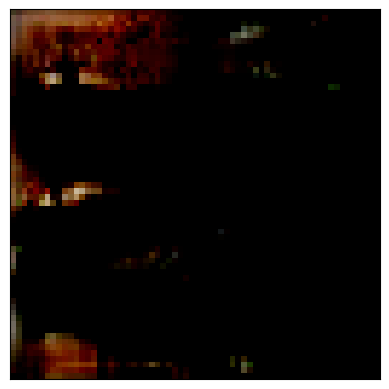

 12%|█▎        | 1/8 [00:00<00:02,  2.83it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


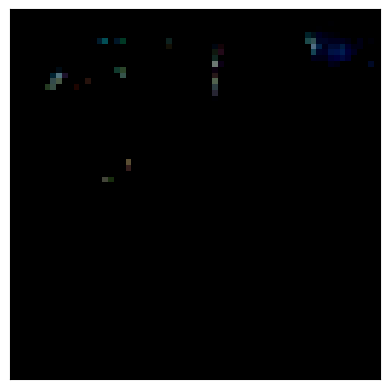

 25%|██▌       | 2/8 [00:00<00:02,  2.74it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


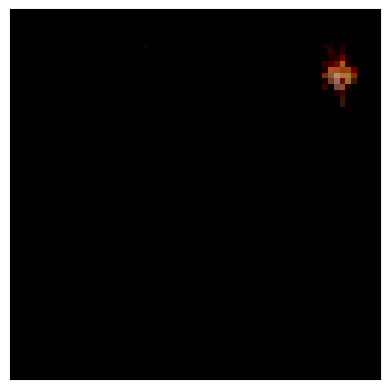

 38%|███▊      | 3/8 [00:01<00:01,  2.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


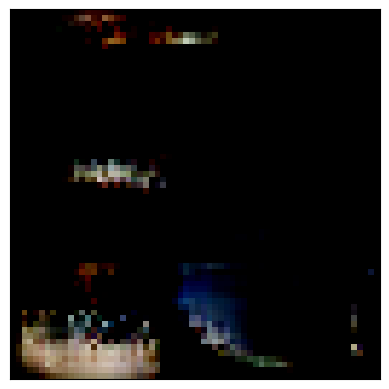

 50%|█████     | 4/8 [00:01<00:01,  2.79it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


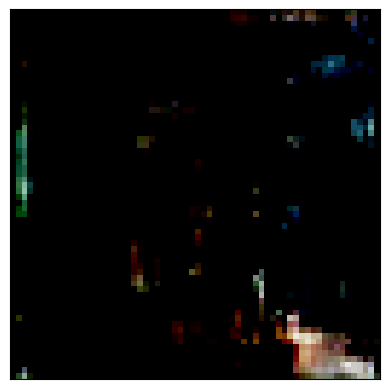

 62%|██████▎   | 5/8 [00:01<00:01,  2.71it/s]

(64, 64, 3)


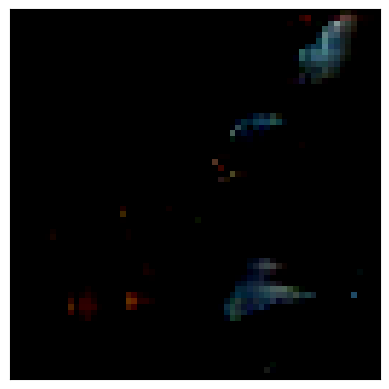

 75%|███████▌  | 6/8 [00:02<00:01,  1.87it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


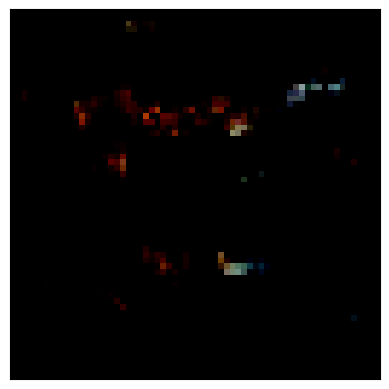

 88%|████████▊ | 7/8 [00:03<00:00,  2.11it/s]

(64, 64, 3)


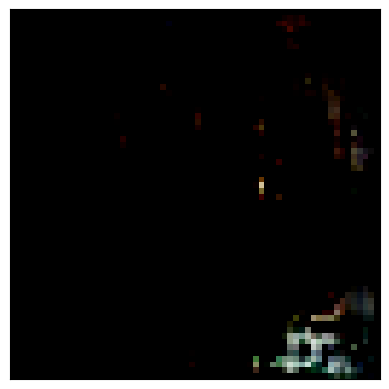

100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


In [ ]:
def load_model(name):
    G = Generator()
    G.load_state_dict(torch.load(f"weight/G{name}.pth", map_location={"cuda:0": "cpu"}))
    G.eval()
    return G.to(device)

#Run on test data!!!
def evaluate(val_dl, name, G):
    with torch.no_grad():
        for input_img, real_img in tqdm(val_dl):
            input_img = input_img.to(device)
            real_img = real_img.to(device)

            fake_img = G(input_img)[0].detach().cpu().numpy()
            fake_img = np.transpose(fake_img, (2,1,0))
            print(fake_img.shape)
            show(fake_img)


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

G=load_model("651")
evaluate(testloader,"na",G)


